## Goal 

We already know the algorithm can produce very bad results. So try to understand which step in the algorithm affects performance the most

In [1]:
import os
import sys
import pandas as pd
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import seaborn as sns
from matplotlib.colors import LogNorm
import pickle

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

np.random.seed(123)

## Simple simulation

In [2]:
n = 1000
p = 1200 ## make this larger to increase difficulty
n_top = 20 ## number of top words in each topic
k = 3
doc_len = 80

X, Atrue, Ftrue, p0 = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len, n_top = n_top)
w_idx = np.where(X.sum(axis = 0) > 0)[0]
X = X[:,w_idx]

In [3]:
%%capture
Ctrue = Ftrue[w_idx,:] @ Atrue @ Ftrue[w_idx,:].T
Strue, Btrue_fit, Atrue_fit, _, _, _, _, _ = factorizeC(Ctrue, K=k, rectifier='no', optimizer='activeSet')

Cfit, _, _ = X2C(sparse.coo_matrix(X))
Sfit, Bfit, Afit, _, _, _, _, Cfit = factorizeC(Cfit, K=k, rectifier='AP', optimizer='activeSet')

Bfit2, Afit2 = recoverAB_givenSC(Cfit, Strue)

In [4]:
print("Atrue")
print(Atrue.round(3))

idx = match_topics(Ftrue, Bfit2).astype(int)
print("Afit2")
print(Afit2[np.ix_(idx, idx)].round(3))

idx = match_topics(Ftrue, Bfit).astype(int)
print("Afit")
print(Afit[np.ix_(idx, idx)].round(3))

Atrue
[[0.258 0.036 0.035]
 [0.036 0.25  0.037]
 [0.035 0.037 0.276]]
Afit2
[[0.26  0.039 0.032]
 [0.039 0.247 0.039]
 [0.032 0.039 0.275]]
Afit
[[0.394 0.    0.   ]
 [0.    0.413 0.   ]
 [0.    0.    0.393]]


true F vs fitted F (know S)


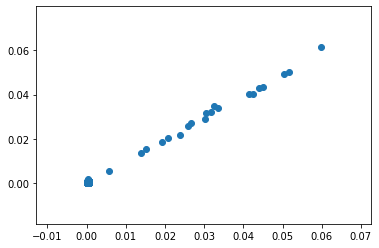

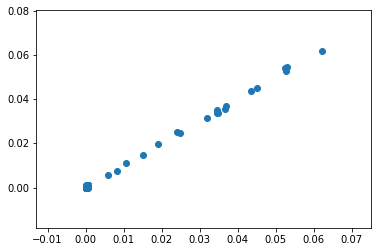

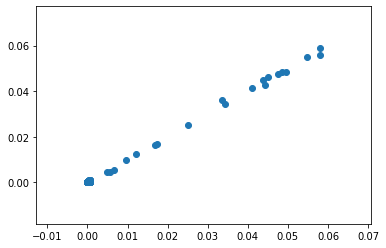

In [5]:
idx = match_topics(Ftrue, Bfit2).astype(int)
print("true F vs fitted F (know S)")
for i in range(k):
    plt.scatter(Ftrue[:, i], Bfit2[:, idx[i]])
    plt.show()

## More realistic data

In [6]:
## load data
dataname = "sla"
k = 6
rate=3

datafile=f"output/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
X = fitted['X']
Atrue = fitted['Atrue']
Ftrue = fitted['Ftrue']
Strue = fitted['S0']
Sfit = fitted['S']


Bfit = fitted['B']
Bfit2 = fitted['B2']

Afit = fitted['A']
Afit2 = fitted['A2']

In [7]:
print("Atrue")
print(Atrue.round(3))

idx = match_topics(Ftrue, Bfit2).astype(int)
print("Afit2")
print(Afit2[np.ix_(idx, idx)].round(3))

idx = match_topics(Ftrue, Bfit).astype(int)
print("Afit")
print(Afit[np.ix_(idx, idx)].round(3))

Atrue
[[0.109 0.014 0.024 0.018 0.016 0.006]
 [0.014 0.084 0.018 0.011 0.01  0.008]
 [0.024 0.018 0.136 0.022 0.016 0.017]
 [0.018 0.011 0.022 0.115 0.013 0.005]
 [0.016 0.01  0.016 0.013 0.08  0.008]
 [0.006 0.008 0.017 0.005 0.008 0.065]]
Afit2
[[0.097 0.011 0.032 0.018 0.014 0.007]
 [0.011 0.084 0.023 0.01  0.008 0.008]
 [0.032 0.023 0.146 0.024 0.018 0.02 ]
 [0.018 0.01  0.024 0.107 0.01  0.004]
 [0.014 0.008 0.018 0.01  0.077 0.007]
 [0.007 0.008 0.02  0.004 0.007 0.062]]
Afit
[[0.252 0.    0.    0.    0.    0.   ]
 [0.    0.187 0.    0.    0.    0.   ]
 [0.    0.    0.405 0.    0.    0.   ]
 [0.    0.    0.    0.205 0.    0.   ]
 [0.    0.    0.    0.    0.226 0.   ]
 [0.    0.    0.    0.    0.    0.114]]


true F vs fitted F (know S)


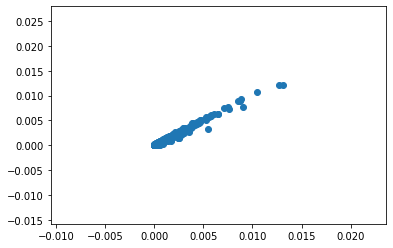

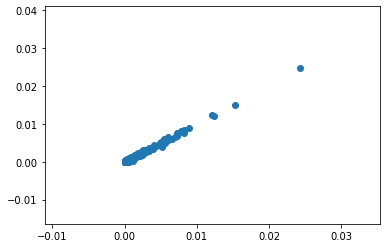

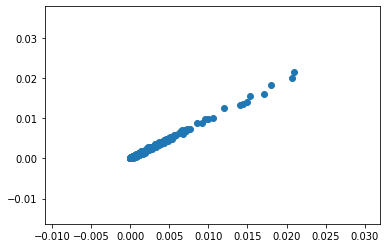

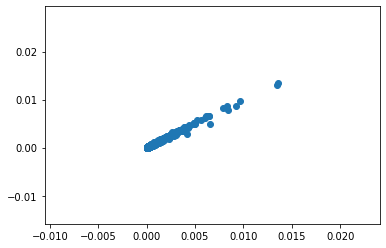

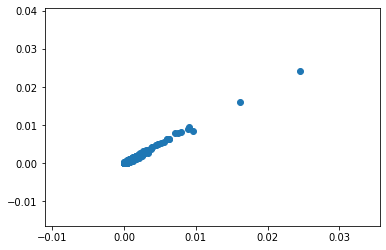

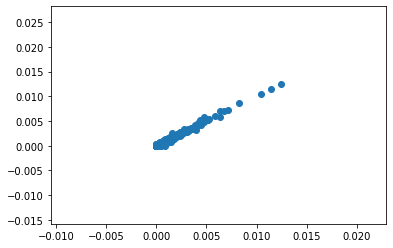

In [8]:
idx = match_topics(Ftrue, Bfit2).astype(int)
print("true F vs fitted F (know S)")
for i in range(k):
    plt.scatter(Ftrue[:, i], Bfit2[:, idx[i]])
    plt.show()

## Comment:

* Can see `recoverS` is the bottleneck. Can be seen in other experiments that `recoverS` finds very bad anchor words and produce nonsense results. 

* Estimate of $A$ only depends on those anchor words, where $C_{s_k, s_l}$ are generally estimated very well. Estimate of $F$ depends on $C_{ij}$ only entry-wise. But `recoverS` depends on the entire $C$.   